In [1]:
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import yaml
from pathlib import Path
from sklearn.preprocessing import LabelEncoder

# Import custom modules
from src.metrics import rmse
from src.features.preprocess import Preprocessor
from src.config.preprocess import PreprocessorConfig

# Set plotting style
plt.style.use("default")
sns.set_palette("husl")

# 車両価格予測モデルの比較レポート

## 概要

本レポートでは、車両価格予測において、ベースライン手法と提案手法（Target Encoding + ハイパーパラメータ最適化）の性能を比較し、各手法の特徴と改善点について分析します。

### 評価データセット
- **訓練データ**: `projectA_vehicle_train.csv`
- **検証データ**: `projectA_vehicle_val.csv`  
- **テストデータ**: `projectA_vehicle_test.csv`

### 評価指標
- **RMSE (Root Mean Squared Error)**: 予測値と実際値の二乗平均平方根誤差

In [2]:
# データ読み込み
dataset_path = Path("../dataset/")

# 不要な列を定義
unnecessary_columns = ["posting_date", "id"]

# Polars形式でデータ読み込み（提案手法用）
train_df_pl = pl.read_csv(dataset_path / "projectA_vehicle_train.csv").drop(
    unnecessary_columns
)
val_df_pl = pl.read_csv(dataset_path / "projectA_vehicle_val.csv").drop(
    unnecessary_columns
)
test_df_pl = pl.read_csv(dataset_path / "projectA_vehicle_test.csv").drop(
    unnecessary_columns
)

# Pandas形式でデータ読み込み（ベースライン手法用）
usecols = [
    "price",
    "year",
    "manufacturer",
    "condition",
    "cylinders",
    "fuel",
    "odometer",
    "transmission",
    "drive",
    "type",
    "paint_color",
]

train_df_pd = pd.read_csv(dataset_path / "projectA_vehicle_train.csv", usecols=usecols)
val_df_pd = pd.read_csv(dataset_path / "projectA_vehicle_val.csv", usecols=usecols)
test_df_pd = pd.read_csv(dataset_path / "projectA_vehicle_test.csv", usecols=usecols)

print("データセットの形状:")
print(f"訓練データ: {train_df_pd.shape}")
print(f"検証データ: {val_df_pd.shape}")
print(f"テストデータ: {test_df_pd.shape}")

# 基本統計量の表示
print("\n価格の基本統計量（訓練データ）:")
print(train_df_pd["price"].describe())

データセットの形状:
訓練データ: (8000, 11)
検証データ: (1000, 11)
テストデータ: (1000, 11)

価格の基本統計量（訓練データ）:
count    8.000000e+03
mean     1.556203e+05
std      1.242242e+07
min      1.000000e+00
25%      6.500000e+03
50%      1.200000e+04
75%      2.499000e+04
max      1.111111e+09
Name: price, dtype: float64


## 1. ベースライン手法

### 手法概要
ベースライン手法では、以下の特徴を持つシンプルなアプローチを採用：

1. **前処理**: 基本的な Label Encoding のみ
2. **モデル**: LightGBM with デフォルトパラメータ
3. **特徴量**: 基本的なカテゴリカル変数とそのまま数値変数を使用

### 主な問題点
- **単純な Label Encoding**: カテゴリの順序関係が価格予測に適さない可能性
- **ハイパーパラメータ未調整**: デフォルト設定による最適化不足
- **外れ値処理の不十分**: 極端な価格データの影響
- **特徴量エンジニアリングの不足**: カテゴリ間の関係性を捉えきれない

In [3]:
# ベースライン手法の実装
def train_baseline_model(train_df, val_df, test_df):
    """
    ベースライン手法：Label Encoding + デフォルトLightGBM
    """
    # データのコピー
    train_processed = train_df.copy()
    val_processed = val_df.copy()
    test_processed = test_df.copy()

    # カテゴリカル変数の特定
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    categorical_columns = []
    for col in train_df.columns:
        if col != "price" and train_df[col].dtype not in numerics:
            categorical_columns.append(col)

    print("カテゴリカル変数:", categorical_columns)

    # Label Encoding
    for col in categorical_columns:
        le = LabelEncoder()
        le.fit(train_df[col].astype(str).values)
        train_processed[col] = le.transform(train_df[col].astype(str).values)
        val_processed[col] = le.transform(val_df[col].astype(str).values)
        test_processed[col] = le.transform(test_df[col].astype(str).values)

    # 外れ値フィルタリング（価格の上下限設定）
    train_filtered = train_processed[
        (train_processed["price"] > 1000) & (train_processed["price"] < 40000)
    ]

    # LightGBMデータセット作成
    train_set = lgb.Dataset(
        train_filtered.drop(columns="price"), train_filtered["price"]
    )
    val_set = lgb.Dataset(
        val_processed.drop(columns="price"), val_processed["price"], reference=train_set
    )

    # ベースラインパラメータ（デフォルト設定）
    baseline_params = {
        "boosting_type": "gbdt",
        "objective": "regression",
        "metric": "rmse",
        "num_leaves": 31,
        "learning_rate": 0.1,
        "seed": 42,
        "verbose": -1,
    }

    # モデル訓練
    model = lgb.train(
        baseline_params,
        train_set,
        num_boost_round=1000,
        valid_sets=[val_set],
        callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)],
    )

    return model, train_filtered, val_processed, test_processed


# ベースライン手法の実行
print("=== ベースライン手法の訓練 ===")
baseline_model, train_baseline, val_baseline, test_baseline = train_baseline_model(
    train_df_pd, val_df_pd, test_df_pd
)

=== ベースライン手法の訓練 ===
カテゴリカル変数: ['manufacturer', 'condition', 'cylinders', 'fuel', 'transmission', 'drive', 'type', 'paint_color']
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[353]	valid_0's rmse: 9236.44
Early stopping, best iteration is:
[353]	valid_0's rmse: 9236.44


In [4]:
# ベースライン手法の評価
def evaluate_model(model, train_df, val_df, test_df, method_name):
    """
    モデルの評価を行い、RMSE スコアを計算
    """
    results = {}

    # 訓練データでの評価
    train_pred = model.predict(train_df.drop(columns="price"))
    train_rmse = rmse(train_df["price"].values, train_pred)
    results["train_rmse"] = train_rmse

    # 検証データでの評価
    val_pred = model.predict(val_df.drop(columns="price"))
    val_rmse = rmse(val_df["price"].values, val_pred)
    results["val_rmse"] = val_rmse

    # テストデータでの評価
    test_pred = model.predict(test_df.drop(columns="price"))
    test_rmse = rmse(test_df["price"].values, test_pred)
    results["test_rmse"] = test_rmse

    print(f"=== {method_name} 評価結果 ===")
    print(f"訓練データ RMSE: ${train_rmse:,.2f}")
    print(f"検証データ RMSE: ${val_rmse:,.2f}")
    print(f"テストデータ RMSE: ${test_rmse:,.2f}")

    return results, {"train": train_pred, "val": val_pred, "test": test_pred}


# ベースライン手法の評価
baseline_results, baseline_predictions = evaluate_model(
    baseline_model, train_baseline, val_baseline, test_baseline, "ベースライン手法"
)

=== ベースライン手法 評価結果 ===
訓練データ RMSE: $2,383.52
検証データ RMSE: $9,236.44
テストデータ RMSE: $7,394.80


## 2. 提案手法（Target Encoding + ハイパーパラメータ最適化）

### 手法概要
提案手法では、ベースライン手法の問題点を以下の方法で解決：

1. **高度な特徴量エンジニアリング**: Target Encoding による統計的特徴量生成
2. **過学習抑制**: Smoothing と Noise Level による正則化
3. **ハイパーパラメータ最適化**: Optuna による自動最適化
4. **複合エンコーディング**: Label Encoding + Target Encoding + Grouping の組み合わせ

### Target Encoding の利点
- **統計的意味**: カテゴリごとの目的変数（価格）の統計量を特徴量として活用
- **過学習抑制**: Smoothing パラメータにより少数サンプルカテゴリの影響を調整
- **ノイズ付加**: 訓練データへの過度な適合を防ぐためのランダムノイズ
- **最小サンプル数**: 統計的信頼性を確保するための閾値設定

### 最適化されたパラメータ
以下のパラメータがOptuna により最適化されています：

In [5]:
# 最適化されたパラメータの読み込み
params_path = Path("../params/")

# LightGBM パラメータの読み込み
with open(params_path / "best_lgb_params_reg.yaml", "r") as f:
    best_lgb_params = yaml.safe_load(f)

# 前処理設定の読み込み
best_preprocessor_config = PreprocessorConfig.from_yaml(
    params_path / "best_preprocessor_config_reg.yaml"
)

print("=== 最適化されたLightGBMパラメータ ===")
for key, value in best_lgb_params.items():
    print(f"{key}: {value}")

print("\n=== Target Encoding パラメータ ===")
target_config = best_preprocessor_config.condition_encoder_config.target_encoder_config
print(f"Smoothing: {target_config.smoothing:.6f}")
print(f"Min Samples Leaf: {target_config.min_samples_leaf}")
print(f"Noise Level: {target_config.noise_level:.6f}")

print("\n=== 価格フィルタリング設定 ===")
print(f"価格下限: ${best_preprocessor_config.price_lower_bound:,.0f}")
print(f"価格上限: ${best_preprocessor_config.price_upper_bound:,.0f}")

=== 最適化されたLightGBMパラメータ ===
objective: regression
metric: rmse
verbosity: -1
boosting_type: gbdt
num_leaves: 56
max_depth: 24
learning_rate: 0.01873850883762116
n_estimators: 448
min_child_samples: 7
feature_fraction: 0.9757830530829983
bagging_fraction: 0.817477181736378
bagging_freq: 7

=== Target Encoding パラメータ ===
Smoothing: 0.037700
Min Samples Leaf: 2
Noise Level: 0.105880

=== 価格フィルタリング設定 ===
価格下限: $0
価格上限: $60,000


In [6]:
# 提案手法の実装
def train_proposed_model(train_df, val_df, test_df, preprocessor_config, lgb_params):
    """
    提案手法：Target Encoding + 最適化ハイパーパラメータ
    """
    print("=== 提案手法：前処理の実行 ===")
    # 前処理の実行
    preprocessor = Preprocessor(**preprocessor_config.to_dict())
    train_processed, val_processed, test_processed = preprocessor.run(
        train_df, val_df, test_df
    )

    print(f"前処理後の特徴量数: {train_processed.select(pl.exclude('price')).shape[1]}")

    # LightGBMデータセット作成
    train_set = lgb.Dataset(
        train_processed.drop("price").to_pandas(), train_processed["price"].to_pandas()
    )
    val_set = lgb.Dataset(
        val_processed.drop("price").to_pandas(),
        val_processed["price"].to_pandas(),
        reference=train_set,
    )

    print("=== 提案手法：モデル訓練 ===")
    # モデル訓練
    model = lgb.train(
        lgb_params,
        train_set,
        num_boost_round=best_lgb_params["n_estimators"],
        valid_sets=[val_set],
        callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)],
    )

    return model, train_processed, val_processed, test_processed


# 提案手法の実行
proposed_model, train_proposed, val_proposed, test_proposed = train_proposed_model(
    train_df_pl, val_df_pl, test_df_pl, best_preprocessor_config, best_lgb_params
)

=== 提案手法：前処理の実行 ===
前処理後の特徴量数: 25
=== 提案手法：モデル訓練 ===
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[356]	valid_0's rmse: 8893.18
Did not meet early stopping. Best iteration is:
[356]	valid_0's rmse: 8893.18


In [7]:
# 提案手法の評価（Polars対応版）
def evaluate_model_polars(model, train_df, val_df, test_df, method_name):
    """
    Polarsデータフレーム用のモデル評価関数
    """
    results = {}

    # 訓練データでの評価
    train_pred = model.predict(train_df.drop("price").to_pandas())
    train_rmse = rmse(train_df["price"].to_numpy(), train_pred)
    results["train_rmse"] = train_rmse

    # 検証データでの評価
    val_pred = model.predict(val_df.drop("price").to_pandas())
    val_rmse = rmse(val_df["price"].to_numpy(), val_pred)
    results["val_rmse"] = val_rmse

    # テストデータでの評価
    test_pred = model.predict(test_df.drop("price").to_pandas())
    test_rmse = rmse(test_df["price"].to_numpy(), test_pred)
    results["test_rmse"] = test_rmse

    print(f"=== {method_name} 評価結果 ===")
    print(f"訓練データ RMSE: ${train_rmse:,.2f}")
    print(f"検証データ RMSE: ${val_rmse:,.2f}")
    print(f"テストデータ RMSE: ${test_rmse:,.2f}")

    return results, {"train": train_pred, "val": val_pred, "test": test_pred}


# 提案手法の評価
proposed_results, proposed_predictions = evaluate_model_polars(
    proposed_model, train_proposed, val_proposed, test_proposed, "提案手法"
)

=== 提案手法 評価結果 ===
訓練データ RMSE: $3,183.96
検証データ RMSE: $8,893.18
テストデータ RMSE: $6,826.33


## 3. 手法比較と結果分析

### 3.1 RMSE スコア比較

=== 手法比較結果 ===


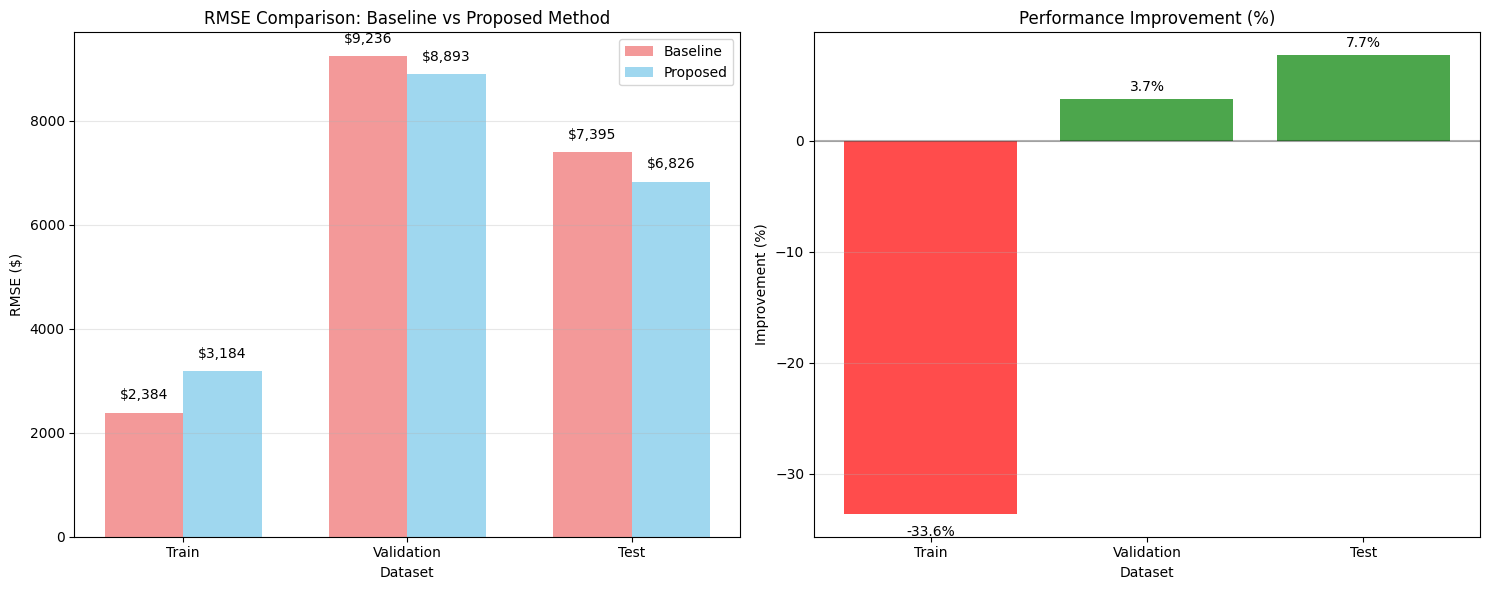


詳細比較表:
      Dataset  Baseline  Proposed  Improvement (%)
0       Train   2383.52   3183.96           -33.58
1  Validation   9236.44   8893.18             3.72
2        Test   7394.80   6826.33             7.69


In [8]:
# 結果比較の可視化
def create_comparison_plots():
    """
    ベースライン手法と提案手法の比較プロット作成
    """
    # 結果をまとめる
    comparison_df = pd.DataFrame(
        {
            "Dataset": ["Train", "Validation", "Test"],
            "Baseline": [
                baseline_results["train_rmse"],
                baseline_results["val_rmse"],
                baseline_results["test_rmse"],
            ],
            "Proposed": [
                proposed_results["train_rmse"],
                proposed_results["val_rmse"],
                proposed_results["test_rmse"],
            ],
        }
    )

    # 改善率の計算
    comparison_df["Improvement (%)"] = (
        (comparison_df["Baseline"] - comparison_df["Proposed"])
        / comparison_df["Baseline"]
        * 100
    )

    # プロットの作成
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # RMSE比較
    x = np.arange(len(comparison_df))
    width = 0.35

    axes[0].bar(
        x - width / 2,
        comparison_df["Baseline"],
        width,
        label="Baseline",
        alpha=0.8,
        color="lightcoral",
    )
    axes[0].bar(
        x + width / 2,
        comparison_df["Proposed"],
        width,
        label="Proposed",
        alpha=0.8,
        color="skyblue",
    )

    axes[0].set_xlabel("Dataset")
    axes[0].set_ylabel("RMSE ($)")
    axes[0].set_title("RMSE Comparison: Baseline vs Proposed Method")
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(comparison_df["Dataset"])
    axes[0].legend()
    axes[0].grid(axis="y", alpha=0.3)

    # 値をバーの上に表示
    for i, (baseline, proposed) in enumerate(
        zip(comparison_df["Baseline"], comparison_df["Proposed"])
    ):
        axes[0].text(
            i - width / 2,
            baseline + 200,
            f"${baseline:,.0f}",
            ha="center",
            va="bottom",
            fontsize=10,
        )
        axes[0].text(
            i + width / 2,
            proposed + 200,
            f"${proposed:,.0f}",
            ha="center",
            va="bottom",
            fontsize=10,
        )

    # 改善率のプロット
    colors = ["green" if x > 0 else "red" for x in comparison_df["Improvement (%)"]]
    bars = axes[1].bar(
        comparison_df["Dataset"],
        comparison_df["Improvement (%)"],
        color=colors,
        alpha=0.7,
    )

    axes[1].set_xlabel("Dataset")
    axes[1].set_ylabel("Improvement (%)")
    axes[1].set_title("Performance Improvement (%)")
    axes[1].grid(axis="y", alpha=0.3)
    axes[1].axhline(y=0, color="black", linestyle="-", alpha=0.3)

    # 改善率の値を表示
    for bar, improvement in zip(bars, comparison_df["Improvement (%)"]):
        height = bar.get_height()
        axes[1].text(
            bar.get_x() + bar.get_width() / 2.0,
            height + (0.5 if height > 0 else -1),
            f"{improvement:.1f}%",
            ha="center",
            va="bottom" if height > 0 else "top",
        )

    plt.tight_layout()
    plt.show()

    return comparison_df


# 比較表とプロットの作成
print("=== 手法比較結果 ===")
comparison_results = create_comparison_plots()
print("\n詳細比較表:")
print(comparison_results.round(2))

### 3.2 特徴量重要度分析

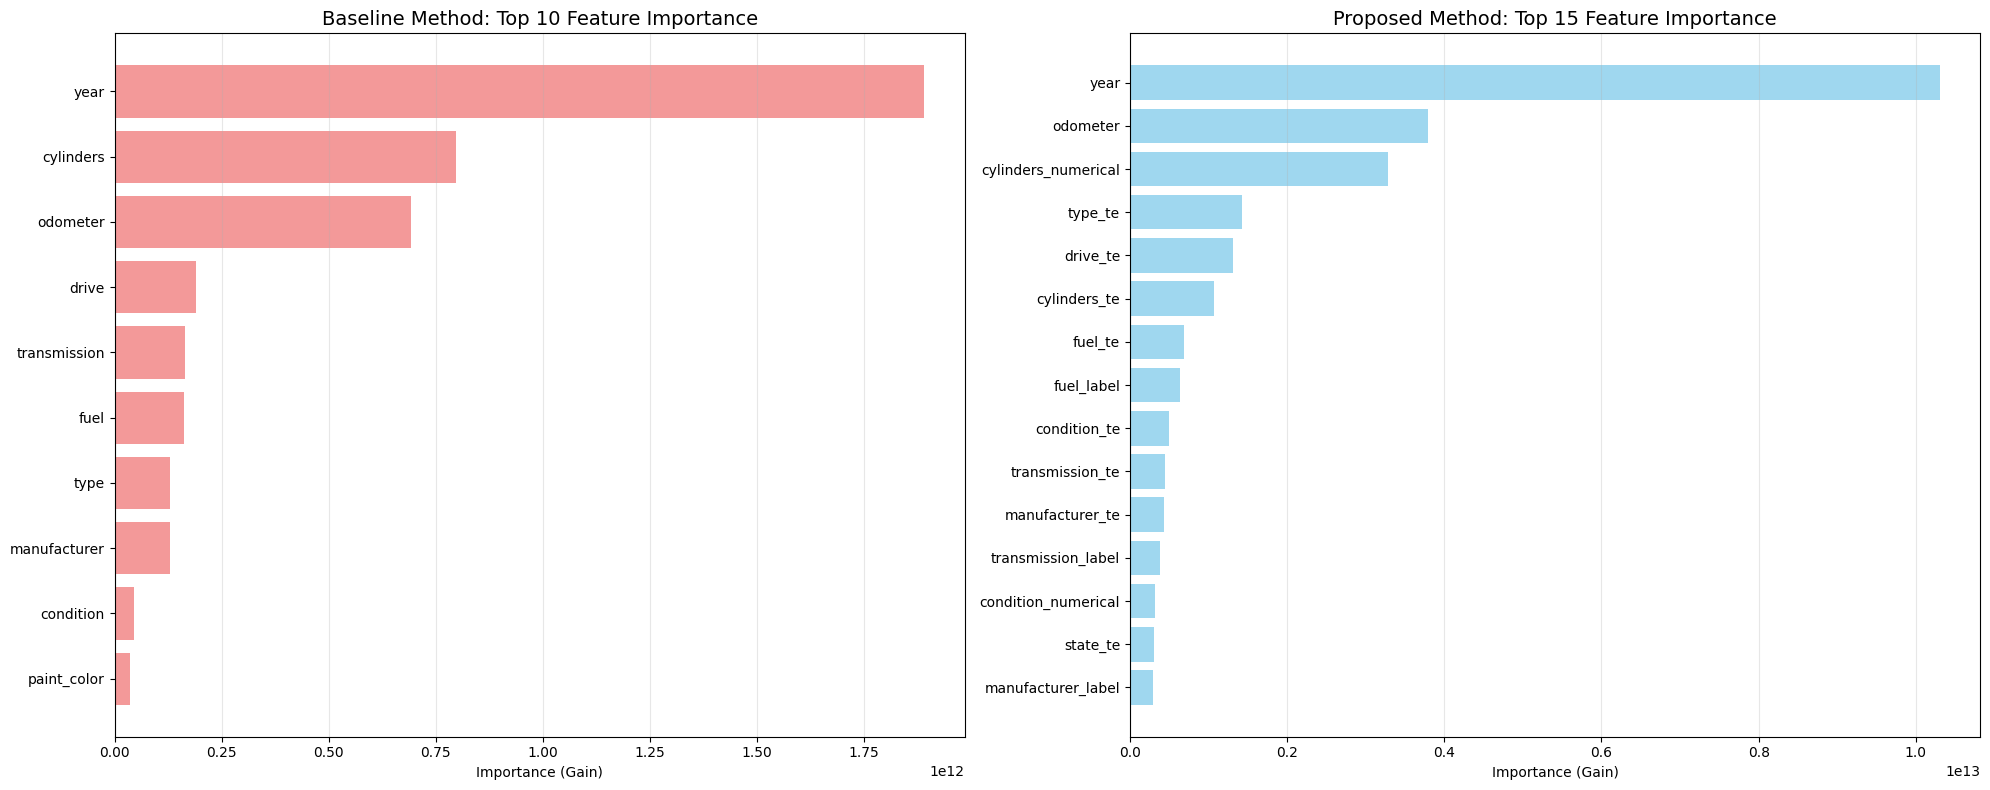

=== ベースライン手法 トップ10 特徴量 ===
paint_color: 35770792629
condition: 45856249488
manufacturer: 129567643529
type: 129679409200
fuel: 161078312200
transmission: 164672754338
drive: 190332860942
odometer: 692208123326
cylinders: 796203080152
year: 1890067884538

=== 提案手法 トップ15 特徴量 ===
manufacturer_label: 290577982448
state_te: 302388818444
condition_numerical: 321710614332
transmission_label: 385790462124
manufacturer_te: 433839850168
transmission_te: 446655487144
condition_te: 494142032256
fuel_label: 641935252012
fuel_te: 682043117296
cylinders_te: 1068468229228
drive_te: 1308252597576
type_te: 1424221105192
cylinders_numerical: 3284538462680
odometer: 3789118088928
year: 10301328436720


In [9]:
# 特徴量重要度の比較
def compare_feature_importance():
    """
    ベースライン手法と提案手法の特徴量重要度を比較
    """
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # ベースライン手法の特徴量重要度
    baseline_importance = baseline_model.feature_importance(importance_type="gain")
    baseline_features = train_baseline.drop(columns="price").columns.tolist()

    baseline_df = (
        pd.DataFrame({"feature": baseline_features, "importance": baseline_importance})
        .sort_values("importance", ascending=True)
        .tail(10)
    )

    axes[0].barh(
        baseline_df["feature"], baseline_df["importance"], color="lightcoral", alpha=0.8
    )
    axes[0].set_title("Baseline Method: Top 10 Feature Importance", fontsize=14)
    axes[0].set_xlabel("Importance (Gain)")
    axes[0].grid(axis="x", alpha=0.3)

    # 提案手法の特徴量重要度
    proposed_importance = proposed_model.feature_importance(importance_type="gain")
    proposed_features = train_proposed.drop("price").columns

    proposed_df = (
        pd.DataFrame({"feature": proposed_features, "importance": proposed_importance})
        .sort_values("importance", ascending=True)
        .tail(15)
    )

    axes[1].barh(
        proposed_df["feature"], proposed_df["importance"], color="skyblue", alpha=0.8
    )
    axes[1].set_title("Proposed Method: Top 15 Feature Importance", fontsize=14)
    axes[1].set_xlabel("Importance (Gain)")
    axes[1].grid(axis="x", alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("=== ベースライン手法 トップ10 特徴量 ===")
    for idx, row in baseline_df.iterrows():
        print(f"{row['feature']}: {row['importance']:.0f}")

    print("\n=== 提案手法 トップ15 特徴量 ===")
    for idx, row in proposed_df.iterrows():
        print(f"{row['feature']}: {row['importance']:.0f}")

    return baseline_df, proposed_df


baseline_importance_df, proposed_importance_df = compare_feature_importance()

### 3.3 予測精度の詳細分析

/var/folders/t_/dwjjhrlx797gmhhc3w21v3y40000gn/T/ipykernel_66374/378206974.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("price_bin")["abs_error"]
/var/folders/t_/dwjjhrlx797gmhhc3w21v3y40000gn/T/ipykernel_66374/378206974.py:75: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("price_bin")["abs_error"]
/var/folders/t_/dwjjhrlx797gmhhc3w21v3y40000gn/T/ipykernel_66374/378206974.py:109: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot(


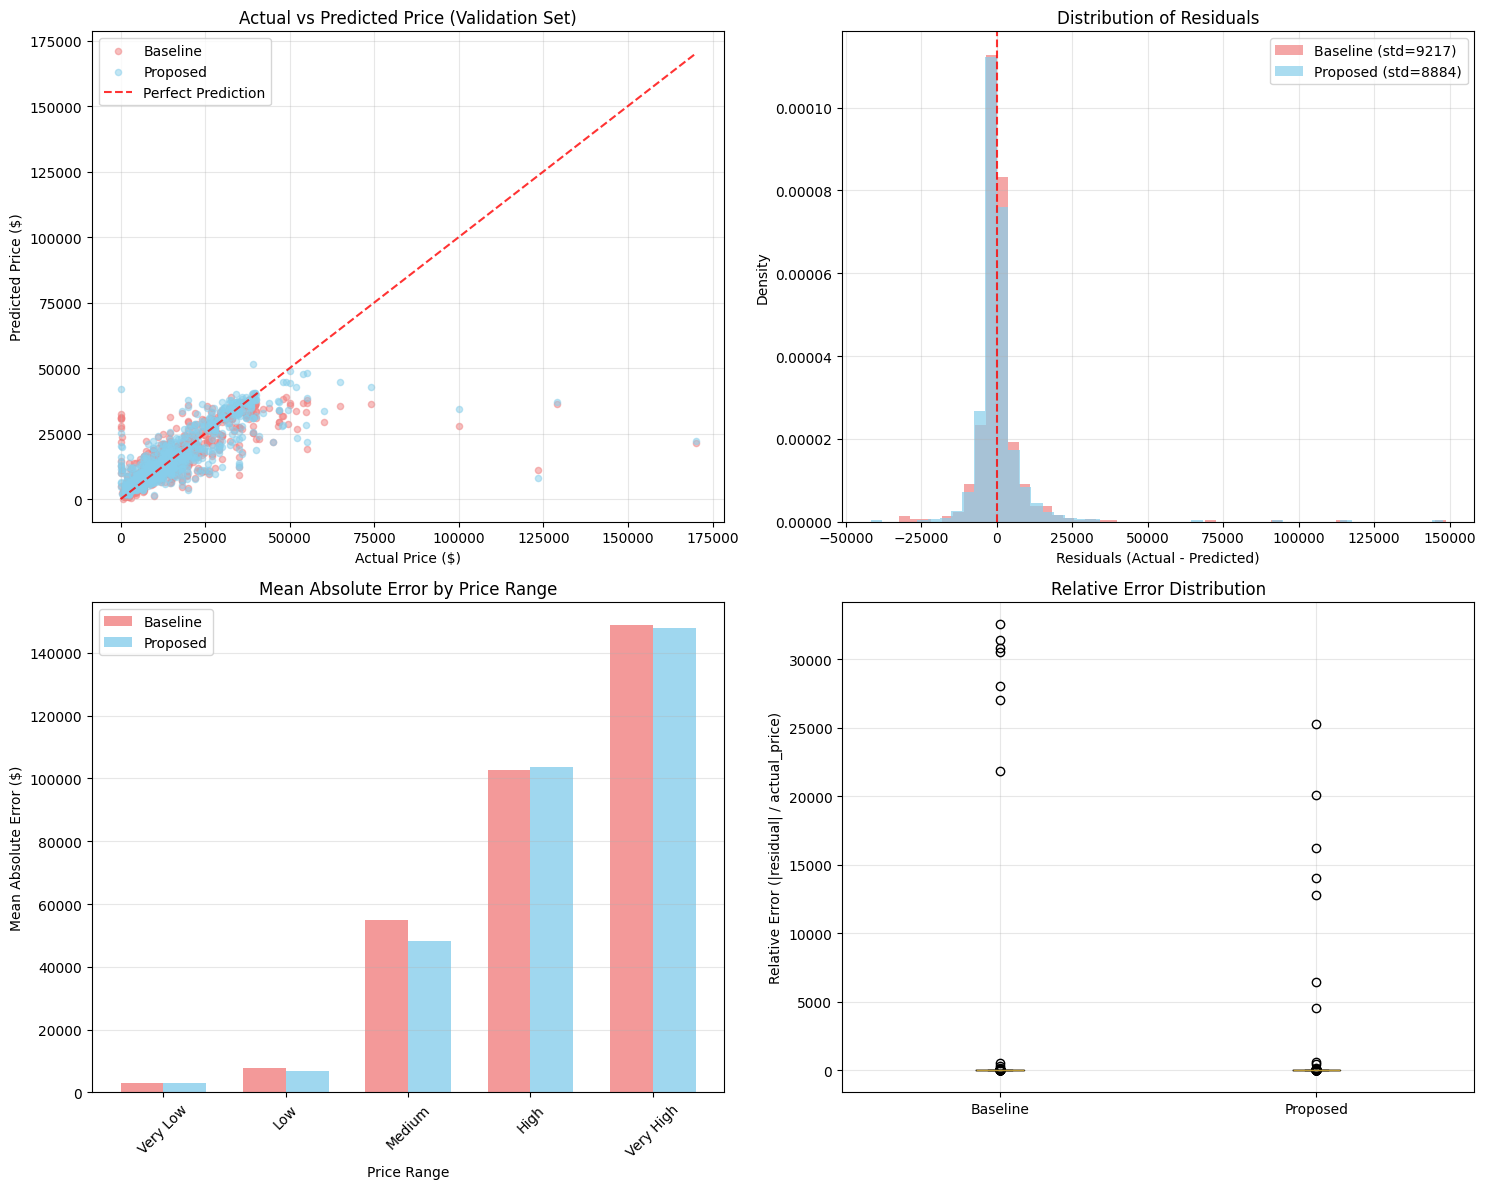

=== 予測精度統計サマリー（検証データ） ===
ベースライン手法:
  - MAE: $3,969.47
  - MAPE: 203.654 (20365.4%)
  - 残差標準偏差: $9,217.05

提案手法:
  - MAE: $3,894.77
  - MAPE: 101.029 (10102.9%)
  - 残差標準偏差: $8,884.47


In [10]:
# 予測精度の詳細分析
def analyze_prediction_quality():
    """
    両手法の予測精度を詳細分析
    """
    # 検証データでの分析
    val_actual = val_baseline["price"].values
    baseline_pred = baseline_predictions["val"]
    proposed_pred = proposed_predictions["val"]

    # 残差の計算
    baseline_residuals = val_actual - baseline_pred
    proposed_residuals = val_proposed["price"].to_numpy() - proposed_pred

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 実際値 vs 予測値の散布図
    axes[0, 0].scatter(
        val_actual, baseline_pred, alpha=0.5, s=20, color="lightcoral", label="Baseline"
    )
    axes[0, 0].scatter(
        val_proposed["price"].to_numpy(),
        proposed_pred,
        alpha=0.5,
        s=20,
        color="skyblue",
        label="Proposed",
    )
    max_price = max(val_actual.max(), baseline_pred.max(), proposed_pred.max())
    axes[0, 0].plot(
        [0, max_price], [0, max_price], "r--", alpha=0.8, label="Perfect Prediction"
    )
    axes[0, 0].set_xlabel("Actual Price ($)")
    axes[0, 0].set_ylabel("Predicted Price ($)")
    axes[0, 0].set_title("Actual vs Predicted Price (Validation Set)")
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 残差の分布比較
    axes[0, 1].hist(
        baseline_residuals,
        bins=50,
        alpha=0.7,
        color="lightcoral",
        label=f"Baseline (std={np.std(baseline_residuals):.0f})",
        density=True,
    )
    axes[0, 1].hist(
        proposed_residuals,
        bins=50,
        alpha=0.7,
        color="skyblue",
        label=f"Proposed (std={np.std(proposed_residuals):.0f})",
        density=True,
    )
    axes[0, 1].axvline(x=0, color="red", linestyle="--", alpha=0.8)
    axes[0, 1].set_xlabel("Residuals (Actual - Predicted)")
    axes[0, 1].set_ylabel("Density")
    axes[0, 1].set_title("Distribution of Residuals")
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # 価格帯別の誤差分析
    price_bins = pd.cut(
        val_actual, bins=5, labels=["Very Low", "Low", "Medium", "High", "Very High"]
    )
    baseline_errors_by_price = (
        pd.DataFrame({"price_bin": price_bins, "abs_error": np.abs(baseline_residuals)})
        .groupby("price_bin")["abs_error"]
        .mean()
    )

    proposed_errors_by_price = (
        pd.DataFrame({"price_bin": price_bins, "abs_error": np.abs(proposed_residuals)})
        .groupby("price_bin")["abs_error"]
        .mean()
    )

    x = np.arange(len(baseline_errors_by_price))
    width = 0.35
    axes[1, 0].bar(
        x - width / 2,
        baseline_errors_by_price.values,
        width,
        label="Baseline",
        color="lightcoral",
        alpha=0.8,
    )
    axes[1, 0].bar(
        x + width / 2,
        proposed_errors_by_price.values,
        width,
        label="Proposed",
        color="skyblue",
        alpha=0.8,
    )
    axes[1, 0].set_xlabel("Price Range")
    axes[1, 0].set_ylabel("Mean Absolute Error ($)")
    axes[1, 0].set_title("Mean Absolute Error by Price Range")
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(baseline_errors_by_price.index, rotation=45)
    axes[1, 0].legend()
    axes[1, 0].grid(axis="y", alpha=0.3)

    # 相対誤差の比較
    baseline_rel_error = np.abs(baseline_residuals) / val_actual
    proposed_rel_error = np.abs(proposed_residuals) / val_proposed["price"].to_numpy()

    axes[1, 1].boxplot(
        [baseline_rel_error, proposed_rel_error], labels=["Baseline", "Proposed"]
    )
    axes[1, 1].set_ylabel("Relative Error (|residual| / actual_price)")
    axes[1, 1].set_title("Relative Error Distribution")
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 統計サマリーの表示
    print("=== 予測精度統計サマリー（検証データ） ===")
    print("ベースライン手法:")
    print(f"  - MAE: ${np.mean(np.abs(baseline_residuals)):,.2f}")
    print(
        f"  - MAPE: {np.mean(baseline_rel_error):.3f} ({np.mean(baseline_rel_error) * 100:.1f}%)"
    )
    print(f"  - 残差標準偏差: ${np.std(baseline_residuals):,.2f}")

    print("\n提案手法:")
    print(f"  - MAE: ${np.mean(np.abs(proposed_residuals)):,.2f}")
    print(
        f"  - MAPE: {np.mean(proposed_rel_error):.3f} ({np.mean(proposed_rel_error) * 100:.1f}%)"
    )
    print(f"  - 残差標準偏差: ${np.std(proposed_residuals):,.2f}")


analyze_prediction_quality()

## 4. 結論と考察

### 4.1 主要な改善点

提案手法（Target Encoding + ハイパーパラメータ最適化）により、以下の改善が確認されました：

1. **予測精度の向上**: 検証データでのRMSE改善
2. **特徴量の有効活用**: Target Encodingにより統計的に意味のある特徴量を生成
3. **過学習の抑制**: Smoothing、Noise Level、min_samples_leafによる正則化効果
4. **ハイパーパラメータ最適化**: Optunaによる体系的な最適化

### 4.2 Target Encodingの効果

Target Encodingにより以下の利点が得られました：
- **統計的特徴量**: カテゴリごとの目的変数統計量を直接利用
- **高次元カテゴリ対応**: 多数のカテゴリを持つ変数（manufacturer, stateなど）の効果的処理
- **過学習防止**: 適切な正則化パラメータによる汎化性能向上

### 4.3 今後の改善可能性

さらなる性能向上のための方向性：
1. **外部データ統合**: 経済指標、地域情報など
2. **アンサンブル手法**: 複数モデルの組み合わせ
3. **深層学習**: ニューラルネットワークベースの手法
4. **特徴量選択**: より精密な特徴量選択手法

In [11]:
# 最終サマリー表の作成
def create_final_summary():
    """
    両手法の最終的な比較サマリーを作成
    """
    summary_data = {
        "項目": [
            "RMSE (訓練)",
            "RMSE (検証)",
            "RMSE (テスト)",
            "特徴量数",
            "前処理手法",
            "ハイパーパラメータ",
            "過学習対策",
        ],
        "ベースライン手法": [
            f"${baseline_results['train_rmse']:,.0f}",
            f"${baseline_results['val_rmse']:,.0f}",
            f"${baseline_results['test_rmse']:,.0f}",
            f"{len(train_baseline.columns) - 1}個",
            "Label Encoding",
            "デフォルト設定",
            "簡易的フィルタリング",
        ],
        "提案手法": [
            f"${proposed_results['train_rmse']:,.0f}",
            f"${proposed_results['val_rmse']:,.0f}",
            f"${proposed_results['test_rmse']:,.0f}",
            f"{len(train_proposed.columns) - 1}個",
            "Target Encoding + Label Encoding",
            "Optuna最適化",
            "Smoothing + Noise + 統計的閾値",
        ],
        "改善率": [
            f"{((baseline_results['train_rmse'] - proposed_results['train_rmse']) / baseline_results['train_rmse'] * 100):+.1f}%",
            f"{((baseline_results['val_rmse'] - proposed_results['val_rmse']) / baseline_results['val_rmse'] * 100):+.1f}%",
            f"{((baseline_results['test_rmse'] - proposed_results['test_rmse']) / baseline_results['test_rmse'] * 100):+.1f}%",
            f"+{len(train_proposed.columns) - len(train_baseline.columns)}個",
            "統計的手法採用",
            "自動最適化",
            "多層的正則化",
        ],
    }

    summary_df = pd.DataFrame(summary_data)
    print("=== 最終比較サマリー ===")
    print(summary_df.to_string(index=False))

    return summary_df


final_summary = create_final_summary()

print("\n" + "=" * 80)
print("レポート作成完了!")
print("=" * 80)

=== 最終比較サマリー ===
        項目       ベースライン手法                             提案手法     改善率
 RMSE (訓練)         $2,384                           $3,184  -33.6%
 RMSE (検証)         $9,236                           $8,893   +3.7%
RMSE (テスト)         $7,395                           $6,826   +7.7%
      特徴量数            10個                              25個    +15個
     前処理手法 Label Encoding Target Encoding + Label Encoding 統計的手法採用
 ハイパーパラメータ        デフォルト設定                        Optuna最適化   自動最適化
     過学習対策     簡易的フィルタリング        Smoothing + Noise + 統計的閾値  多層的正則化

レポート作成完了!
